In [1]:
#Imports
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import acquire
import summarize
import prepare

### Acquire and Summarize

In [2]:
df = acquire.get_mall_data()
df.head()

this file exists, reading from csv


,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
print(summarize.df_summary(df))

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None

Describe:
                       Age   Annual Income (k$)  Spending Score (1-100)
count               200.00               200.00                  200.00
mean                 38.85                60.56                   50.20
std                  13.97                26.26                   25.82
min                  18.00                15.00                    1.00
25%                  28.75                41.50                   34.75
50%                  36.00                61.50                   50.00
75%          

In [4]:
df = prepare.data_prep(
    df,
    cols_to_remove=[],
    prop_required_column=.6,
    prop_required_row=.75)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual Income (k$)'}>],
       [<Axes: title={'center': 'Spending Score (1-100)'}>, <Axes: >]],
      dtype=object)

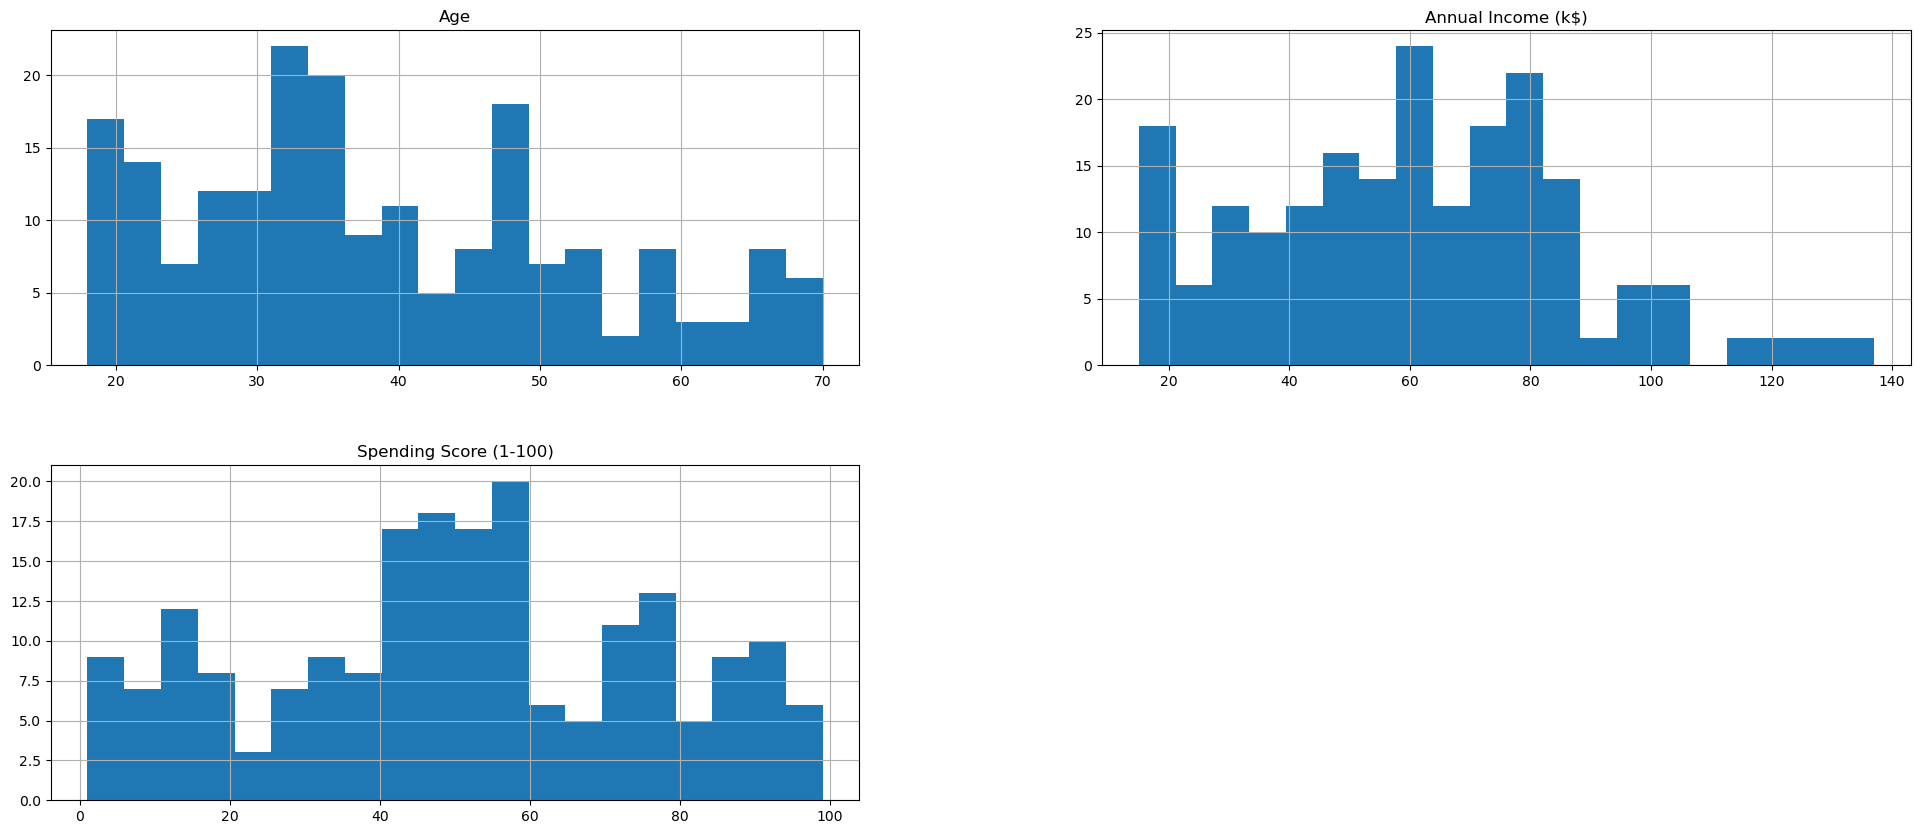

In [5]:
df.hist(figsize=(24, 10), bins=20)

In [6]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=1.5)

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_outliers,Annual Income (k$)_outliers,Spending Score (1-100)_outliers
CustomerID,,,,,,,
1,Male,19,15,39,0,0.00,0
2,Male,21,15,81,0,0.00,0
3,Female,20,16,6,0,0.00,0
4,Female,23,16,77,0,0.00,0
5,Female,31,17,40,0,0.00,0


In [7]:
#This shows the outliers in the data
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

~~~
Age_outliers
count                   0.00
mean                     NaN
std                      NaN
min                      NaN
25%                      NaN
50%                      NaN
75%                      NaN
max                      NaN
Name: Age_outliers, dtype: float64
~~~
Annual Income (k$)_outliers
count                   2.00
mean                    4.25
std                     0.00
min                     4.25
25%                     4.25
50%                     4.25
75%                     4.25
max                     4.25
Name: Annual Income (k$)_outliers, dtype: float64
~~~
Spending Score (1-100)_outliers
count                   0.00
mean                     NaN
std                      NaN
min                      NaN
25%                      NaN
50%                      NaN
75%                      NaN
max                      NaN
Name: Spending Score (1-100)_outliers, dtype: float64



### Plots to see the data

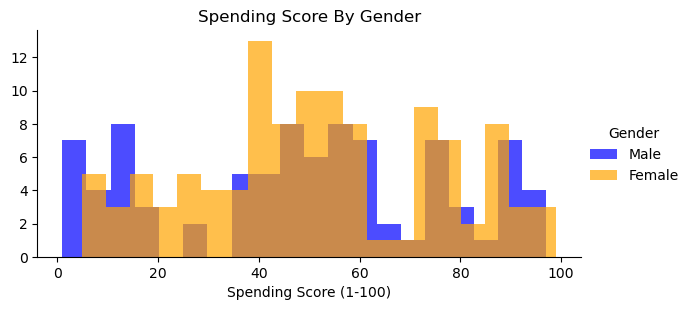

In [8]:
palette = {'Male':'blue', 'Female':'orange'}
gender = sns.FacetGrid(df, hue = 'Gender', aspect = 2, palette = palette)
gender = gender.map(plt.hist, 'Spending Score (1-100)', bins = 20, alpha = 0.7)
plt.title('Spending Score By Gender')
gender.add_legend(title='Gender')
plt.show()

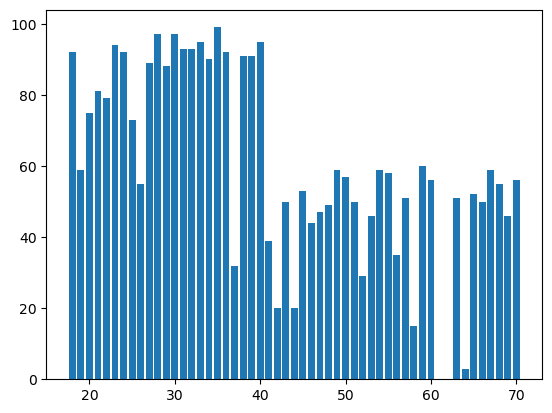

In [9]:
plt.bar(df['Age'],df['Spending Score (1-100)'])
plt.show()

### Split Into Train, Validate, and Test

In [10]:
#Function to split the data
def split_data(df):
    """
    Recieves dataframe as 'df' and target variable to stratify as 'col'
    First split does a 60% train and 40% validate
    Second split uses the 40% validate to make 50% validate and 50% test
    """
    #first split
    train, validate_test = train_test_split(df, #send in initial df
                train_size = 0.60, #size of the train df, and the test size will default to 1-train_size
                random_state = 123, #set any number here for consistency
                )
    
    #second split
    validate, test = train_test_split(validate_test, #we are spliting the 40% df we just made
                test_size = 0.50, #split 50/50
                random_state = 123, #gotta send in a random seed
                )
    print(f'''
Train Shape: {train.shape}
Validate Shape: {validate.shape}
Test Shape: {test.shape}
    ''')
    return train, validate, test

In [11]:
#Get the split data
train, validate, test = split_data(df)


Train Shape: (120, 7)
Validate Shape: (40, 7)
Test Shape: (40, 7)
    


### Encode Categorical Columns

In [12]:
df = pd.get_dummies(df, columns = ['Gender'], dtype=int)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Age_outliers,Annual Income (k$)_outliers,Spending Score (1-100)_outliers,Gender_Female,Gender_Male
CustomerID,,,,,,,,
1,19,15,39,0,0.00,0,0,1
2,21,15,81,0,0.00,0,0,1
3,20,16,6,0,0.00,0,1,0
4,23,16,77,0,0.00,0,1,0
5,31,17,40,0,0.00,0,1,0


### Scaling

In [13]:
columns = ['Age_outliers','Annual Income (k$)_outliers','Spending Score (1-100)_outliers']
df.drop(columns, inplace=True, axis=1)

In [14]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0,1
2,21,15,81,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0


<Axes: xlabel='Gender_Male'>

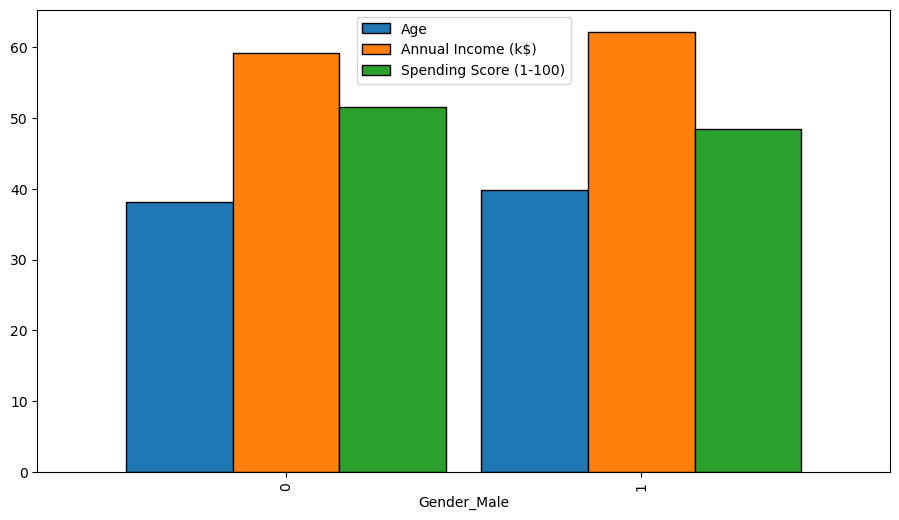

In [15]:
#Without Scaler (0 = Female, 1 = Male)
df[['Gender_Male', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']].groupby(
    'Gender_Male').mean().plot.bar(
    figsize=(11, 6), ec='black', width=.9)

<Axes: xlabel='Gender_Male'>

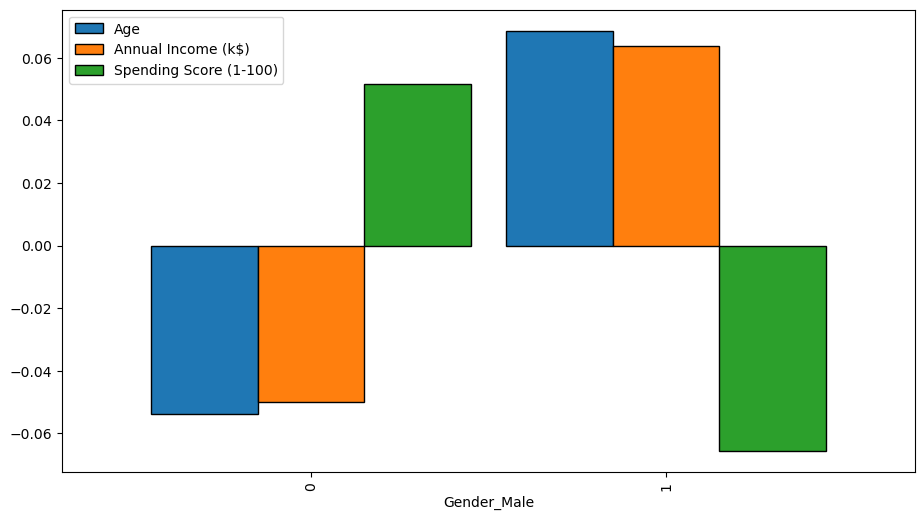

In [16]:
#With Scaler (0 = Female, 1 = Male)
cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])
df[['Gender_Male', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']].groupby('Gender_Male').mean().plot.bar(figsize=(11, 6), ec='black', width=.9)